# Cifar10 dataset

# Import the packages

In [1]:
import torch
import torch.nn as nn
import torchvision

# Setup
# Preprocessing

In [2]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# TODO: investigate the rescalling option
# IMG_SIZE = 160 # origninal img size (32, 32, 3), optimal img size (224, 224, 3)

# Define a transform to normalize the data
transform: Compose = Compose([
    
    Resize((224, 224)),
    
    # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
    # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    ToTensor(), 
    
    # Normalize a tensor image with mean and standard deviation.
    # output[channel] = (input[channel] - mean[channel]) / std[channel] -> normalised = (original - 0.5) / 0.5]
    # Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

## Load the dataset

In [3]:
from torch import Tensor
from torch.utils.data import random_split
from torchvision.datasets import CIFAR10

# load the full CIFAR-10 training data
full_trainset: CIFAR10 = CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform
)

# split the full training data into train and validation sets
train_size: int = int(0.8 * len(full_trainset))
valid_size: int = len(full_trainset) - train_size

# TODO: check annotation type, and understand the function
trainset, validset = random_split(full_trainset, [train_size, valid_size])

# load the test data
testset: CIFAR10 = CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# print dataset sizes
print(f"All samples: {len(trainset)+len(validset)+len(testset)}")
print(f"Train samples: {len(trainset)}")
print(f"Validation samples: {len(validset)}")
print(f"Test samples: {len(testset)}")

# get one sample to check image shape
image, label = full_trainset[0]
print(f"Single image shape: {image.shape}")

All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 224, 224])


## Create data loaders

In [5]:
from torch.utils.data import DataLoader

train_loader: DataLoader = DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=4,    
    pin_memory=True,
    persistent_workers=True
)
# 
# validloader = torch.utils.data.DataLoader(
valid_loader: DataLoader = DataLoader(
    validset,
    batch_size=256,
    shuffle=False,
    num_workers=4,    
    pin_memory=True,
    persistent_workers=True
)

test_loader: DataLoader = DataLoader(
    testset,
    batch_size=256,
    shuffle=False,
    num_workers=4,    
    pin_memory=True,
    persistent_workers=True
)

# Check shapes
xb, yb = next(iter(train_loader))
print("Batch shape:", xb.shape)   # should be [B, 3, 32, 32]

Batch shape: torch.Size([128, 3, 224, 224])


## View a batch of images

Shape before transpose: (3, 3618, 1810)
Shape after transpose: (3618, 1810, 3)


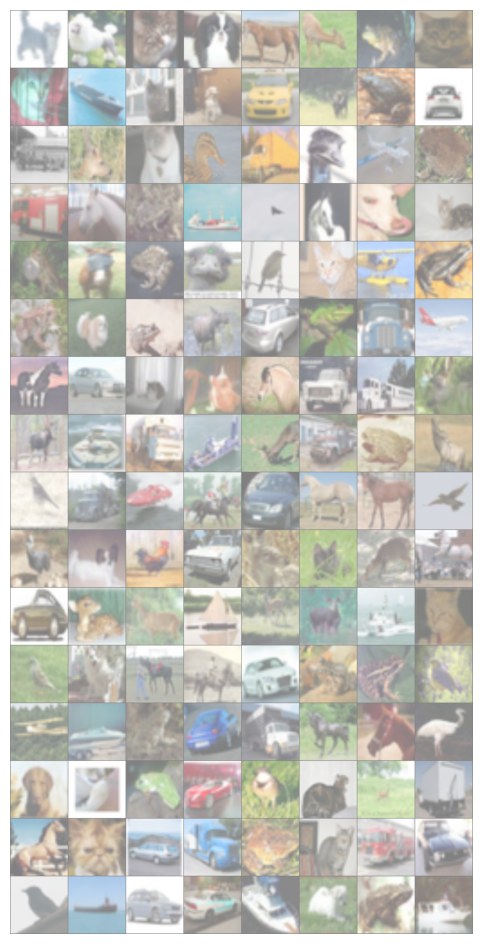

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: check the bug -> it is not an 8 by 8 figure, why?
# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = unnormalized_image_grid.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(train_loader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)


## Get class labels

In [7]:
# TODO: Get the label directly cifar10_classes = cifar10.classes

cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(cifar10_classes [labels[0]])  


cat


In [8]:
cifar10_classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

# Convolutional Variational Autoencoder (Conv-VAE)
https://github.com/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb 

In [9]:
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Model

In [10]:
# ?nn.Linear

In [11]:
# TODO: rename VAE model to CVAE
# TODO: try batchnorm, dropout

import torch
from torch import nn
from collections import namedtuple

VAEOutput = namedtuple("VAEOutput", ["output", "codings_mean", "codings_logvar"])

class CVAE(nn.Module):
    def __init__(self, codings_dim=32, p_drop=0.1):
        """
        Convolutional VAE for 224x224 images.
        Inputs in [0,1]; outputs in [0,1].
        p_drop: dropout probability (try 0.1–0.3)
        """
        super().__init__()
        self.codings_dim = codings_dim

        # --------- Encoder ---------
        self.encoder_cnn = nn.Sequential(
            # 224 -> 112
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),

            # 112 -> 56
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),

            # 56 -> 28
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),

            # 28 -> 14
            nn.Conv2d(128, 192, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop),

            # 14 -> 7
            nn.Conv2d(192, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),

            # keep 7x7 with a 3x3 conv
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(inplace=True),
        )

        self.flat_dim = 256 * 7 * 7  # 12544

        # --------- Variational heads ---------
        self.fc_mu = nn.Sequential(
            nn.Linear(self.flat_dim, codings_dim),
            nn.Dropout(p_drop)
        )
        self.fc_logvar = nn.Sequential(
            nn.Linear(self.flat_dim, codings_dim),
            nn.Dropout(p_drop)
        )

        # --------- Decoder ---------
        self.fc_dec = nn.Linear(codings_dim, self.flat_dim)

        self.decoder_cnn = nn.Sequential(
            # 7 -> 14
            nn.ConvTranspose2d(256, 192, 4, 2, 1),
            nn.BatchNorm2d(192), nn.ReLU(inplace=True),

            # 14 -> 28
            nn.ConvTranspose2d(192, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),

            # 28 -> 56
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),

            # 56 -> 112
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),

            # 112 -> 224
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.BatchNorm2d(16), nn.ReLU(inplace=True),

            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    # --------- Core Methods ---------
    def encode(self, x):
        h = self.encoder_cnn(x).flatten(1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    @staticmethod
    def sample_codings(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 256, 7, 7)
        return self.decoder_cnn(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_codings(mu, logvar)
        output = self.decode(z)
        return VAEOutput(output, mu, logvar)


## Model training

In [27]:
def vae_loss(y_pred, x_target, kl_weight=1.0):
    output, mean, logvar = y_pred
    # MSE reconstruction
    recon = F.mse_loss(output, x_target)
    # recon = F.binary_cross_entropy_with_logits(output, x_target, reduction="mean") # logits + BCEWithLogitsLoss:
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.pow(2), dim=-1).mean()
    # Scale KL to per-pixel magnitude
    n_pixels = x_target[0].numel()
    return recon + kl_weight * (kl_div / n_pixels)

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            out = y_pred.output if isinstance(y_pred, tuple) else y_pred
            metric.update(out, X_batch)  # compare recon to input
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs=20):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        for index, (X_batch, _) in enumerate(train_loader):
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, X_batch)   # use input as target
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            out = y_pred.output if isinstance(y_pred, tuple) else y_pred
            metric.update(out, X_batch)

        train_metric = metric.compute().item()
        val_metric = evaluate_tm(model, valid_loader, metric).item()

        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        history["valid_metrics"].append(val_metric)

        print(f"Epoch {epoch+1:02d}/{n_epochs} "
              f"loss={history['train_losses'][-1]:.4f}, "
              f"train RMSE={train_metric:.4f}, val RMSE={val_metric:.4f}")
    return history


torch.manual_seed(42)
cvae = CVAE(codings_dim=64).to(device)
# TODO: hyperparameter to tune -> learning rate
optimizer = torch.optim.NAdam(cvae.parameters(), lr=1e-4)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)

history = train(cvae, optimizer, vae_loss, rmse, train_loader, valid_loader, n_epochs=20)


Epoch 01/20 loss=0.0265, train RMSE=0.1593, val RMSE=0.1241


Epoch 02/20 loss=0.0166, train RMSE=0.1245, val RMSE=0.1225
Epoch 03/20 loss=0.0156, train RMSE=0.1201, val RMSE=0.1129
Epoch 04/20 loss=0.0146, train RMSE=0.1157, val RMSE=0.1075
Epoch 05/20 loss=0.0129, train RMSE=0.1077, val RMSE=0.1022
Epoch 06/20 loss=0.0123, train RMSE=0.1048, val RMSE=0.1034
Epoch 07/20 loss=0.0120, train RMSE=0.1034, val RMSE=0.0971
Epoch 08/20 loss=0.0118, train RMSE=0.1024, val RMSE=0.0950
Epoch 09/20 loss=0.0116, train RMSE=0.1018, val RMSE=0.0998
Epoch 10/20 loss=0.0115, train RMSE=0.1012, val RMSE=0.0945
Epoch 11/20 loss=0.0115, train RMSE=0.1009, val RMSE=0.0964
Epoch 12/20 loss=0.0114, train RMSE=0.1003, val RMSE=0.0983
Epoch 13/20 loss=0.0113, train RMSE=0.1001, val RMSE=0.0930
Epoch 14/20 loss=0.0112, train RMSE=0.0998, val RMSE=0.0948
Epoch 15/20 loss=0.0112, train RMSE=0.0997, val RMSE=0.0940
Epoch 16/20 loss=0.0112, train RMSE=0.0995, val RMSE=0.0963
Epoch 17/20 loss=0.0111, train RMSE=0.0991, val RMSE=0.0923
Epoch 18/20 loss=0.0111, train RMSE=0.09

Note: Evaluate the range for rmse

## Plot loss

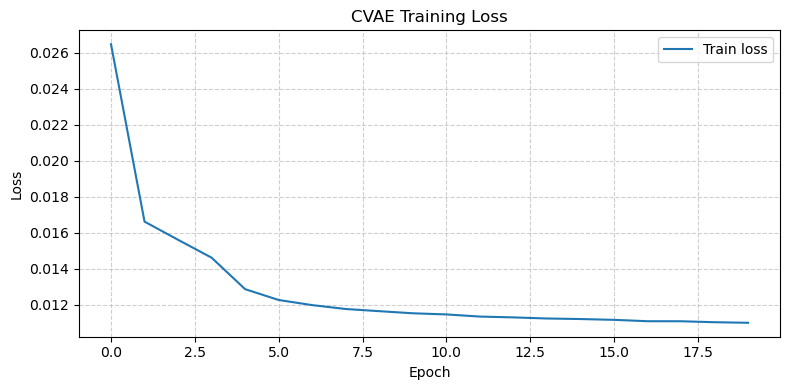

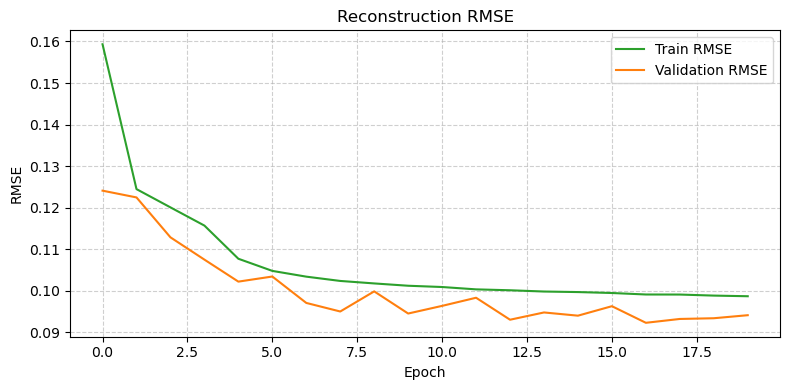

In [28]:
import matplotlib.pyplot as plt

# --- Plot training loss ---
plt.figure(figsize=(8, 4))
plt.plot(history["train_losses"], label="Train loss", color="tab:blue")
plt.title("CVAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot RMSE (train vs validation) ---
plt.figure(figsize=(8, 4))
plt.plot(history["train_metrics"], label="Train RMSE", color="tab:green")
plt.plot(history["valid_metrics"], label="Validation RMSE", color="tab:orange")
plt.title("Reconstruction RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## Visualization

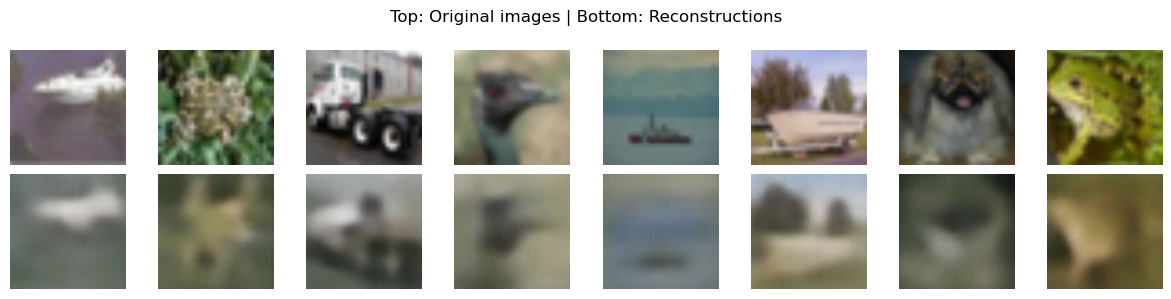

In [29]:
import matplotlib.pyplot as plt
import torch

def plot_image(img):
    """Convert a tensor to a displayable image and plot it."""
    img = img.detach().cpu()
    if img.ndim == 3:
        img = img.permute(1, 2, 0)  # (C,H,W) -> (H,W,C)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

def plot_reconstructions(model, data_loader, n_images=8):
    """
    Show original (top row) and reconstructed (bottom row) images from the VAE.
    """
    model.eval()

    # --- Get a batch of images ---
    X_batch, _ = next(iter(data_loader))
    X_batch = X_batch.to(device)
    X_batch = X_batch[:n_images]  # take first n_images only

    # --- Forward pass ---
    with torch.no_grad():
        out = model(X_batch)
        recon = out.output if hasattr(out, "output") else out

    # --- Plot originals and reconstructions ---
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 1.5, 3))

    for i in range(n_images):
        # Top row: original
        axes[0, i].imshow(X_batch[i].detach().cpu().permute(1, 2, 0))
        axes[0, i].axis("off")

        # Bottom row: reconstruction
        axes[1, i].imshow(recon[i].detach().cpu().permute(1, 2, 0))
        axes[1, i].axis("off")
    

    fig.suptitle("Top: Original images | Bottom: Reconstructions", fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Use it ---
plot_reconstructions(cvae, valid_loader, n_images=8)


# Exploration of the latent represenation (umap)

In [30]:
import torch
import numpy as np

def collect_mu(vae, loader, device):
    vae.eval()
    mus, ys = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = vae(x)
            # Handle both: namedtuple VAEOutput or plain tensor
            mu = out.codings_mean if hasattr(out, "codings_mean") else vae.encode(x)[0]
            mus.append(mu.detach().cpu().numpy())
            ys.append(y.numpy())
    X_mu = np.concatenate(mus, axis=0)   # shape: (N, codings_dim)
    y_all = np.concatenate(ys, axis=0)   # shape: (N,)
    return X_mu, y_all

# Example:
X_train_mu, y_train = collect_mu(cvae, train_loader, device)
X_valid_mu, y_valid = collect_mu(cvae, valid_loader, device)


In [31]:
# pip install umap-learn
import umap
from sklearn.preprocessing import StandardScaler

# TODO: try to improve by playing with the parameters

umap_2d = umap.UMAP(
    n_neighbors=15,      # local vs global structure (try 10–50)
    min_dist=0.1,        # how tight clusters look (0.0–0.5)
    n_components=2,      # 2D for plotting (set 3 for 3D)
    metric="euclidean",  # try "cosine" if features are directional
    random_state=42
)

# Z_train_2d = umap_2d.fit_transform(X_train_mu)  # (N_train, 2)
# Z_valid_2d = umap_2d.transform(X_valid_mu)      # (N_valid, 2)



scaler = StandardScaler().fit(X_train_mu)
X_train_mu_s = scaler.transform(X_train_mu)
X_valid_mu_s = scaler.transform(X_valid_mu)
Z_train_2d = umap_2d.fit_transform(X_train_mu_s)
Z_valid_2d = umap_2d.transform(X_valid_mu_s)


/storage/homefs/ae04q066/.conda/envs/py3.10/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


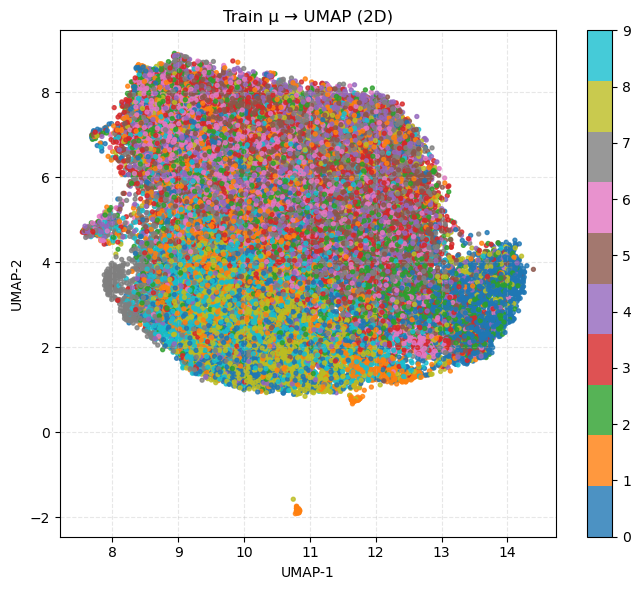

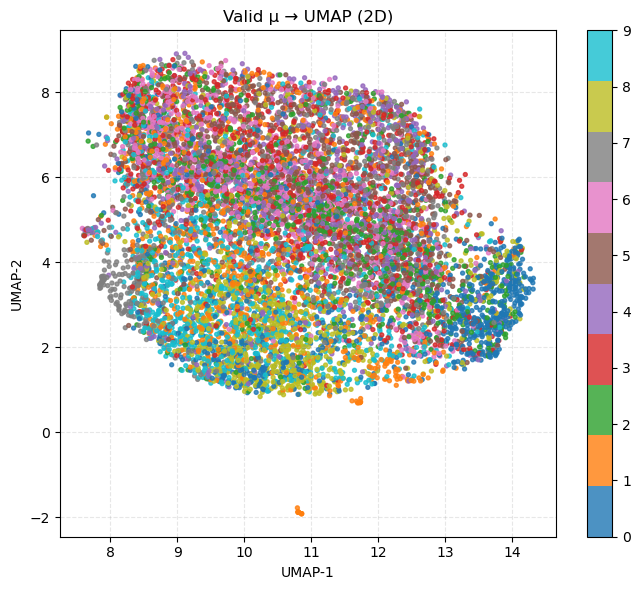

In [32]:
import matplotlib.pyplot as plt

def scatter_umap(Z, y, title="UMAP of VAE μ", num_classes=None):
    plt.figure(figsize=(7,6))
    sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=8, alpha=0.8, cmap="tab10")
    if num_classes is None:
        num_classes = len(np.unique(y))
    plt.colorbar(sc, ticks=range(num_classes))
    plt.title(title)
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.grid(True, ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

scatter_umap(Z_train_2d, y_train, title="Train μ → UMAP (2D)")
scatter_umap(Z_valid_2d, y_valid, title="Valid μ → UMAP (2D)")



Overall structure

* The map shows a continuous, dense cloud rather than distinct clusters.

* That’s expected — your autoencoder is trained unsupervised only to reconstruct images, not to separate classes.

* Therefore, latent codes mainly capture visual similarity (colors, textures, shapes) rather than semantic categories.

# Find outliers
test 

# Sample from the latent distribution

# overlay with data points
What does it mean?

# Feature extraction 
From latent space

In [33]:
import time

device = next(cvae.parameters()).device

# --- helper to collect μ and labels from a loader ---
def collect_mu(cvae, loader, device, name="dataset"):
    cvae.eval()
    mus, ys = [], []
    start_time = time.time()
    total_batches = len(loader)

    print(f"\n[INFO] Extracting features from {name} ({total_batches} batches)...")
    with torch.no_grad():
        for i, (x, y) in enumerate(loader, start=1):
            x = x.to(device, non_blocking=True)
            mu, _ = cvae.encode(x)
            mus.append(mu.detach().cpu().numpy())
            ys.append(y.numpy())

            if i % 20 == 0 or i == total_batches:
                elapsed = time.time() - start_time
                print(f"  Batch {i:>4}/{total_batches} | Time elapsed: {elapsed:5.1f}s")

    X = np.concatenate(mus, axis=0)
    y = np.concatenate(ys, axis=0)
    print(f"[INFO] Done {name}: {X.shape[0]} samples, {X.shape[1]}-dim μs | Total time: {time.time()-start_time:.1f}s\n")
    return X, y


# 1) Extract μ for all splits
X_train, y_train = collect_mu(cvae, train_loader, device, "train set")
X_valid, y_valid = collect_mu(cvae, valid_loader, device, "validation set")
X_test, y_test = collect_mu(cvae, test_loader, device, "test set")

# 2) Standardize
print("[INFO] Standardizing features...")
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)
print("  Done scaling.\n")


[INFO] Extracting features from train set (313 batches)...
  Batch   20/313 | Time elapsed:   0.7s


  Batch   40/313 | Time elapsed:   1.2s
  Batch   60/313 | Time elapsed:   1.8s
  Batch   80/313 | Time elapsed:   2.4s
  Batch  100/313 | Time elapsed:   2.9s
  Batch  120/313 | Time elapsed:   3.5s
  Batch  140/313 | Time elapsed:   4.1s
  Batch  160/313 | Time elapsed:   4.7s
  Batch  180/313 | Time elapsed:   5.3s
  Batch  200/313 | Time elapsed:   5.8s
  Batch  220/313 | Time elapsed:   6.4s
  Batch  240/313 | Time elapsed:   6.9s
  Batch  260/313 | Time elapsed:   7.5s
  Batch  280/313 | Time elapsed:   8.1s
  Batch  300/313 | Time elapsed:   8.6s
  Batch  313/313 | Time elapsed:   9.0s
[INFO] Done train set: 40000 samples, 64-dim μs | Total time: 9.0s


[INFO] Extracting features from validation set (40 batches)...
  Batch   20/40 | Time elapsed:   1.5s
  Batch   40/40 | Time elapsed:   2.7s
[INFO] Done validation set: 10000 samples, 64-dim μs | Total time: 2.7s


[INFO] Extracting features from test set (40 batches)...
  Batch   20/40 | Time elapsed:   1.4s
  Batch   40/40 | Ti

# Train classifier/regressor 
Using the latent space representation of the samples

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix


from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

import time
import numpy as np


## Helper functions

In [35]:
def evaluate_classifier(
    clf, # scikit-learn classifier or pipeline
    X: np.ndarray, 
    y: np.ndarray, 
    name: str="Model")->None:
    
    y_predicted = clf.predict(X)
    print(f"[{name}] Accuracy:", accuracy_score(y, y_predicted))
    print(classification_report(y, y_predicted, digits=4))
    return None

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_valid, y_valid, class_names=None,
                          title="Confusion Matrix", normalize=True, figsize=(7,6)):
    """
    Compute and plot the confusion matrix for a classifier.

    Parameters
    ----------
    model : trained classifier (e.g., SVM, MLP)
        Must implement `.predict()`.
    X_valid : array-like
        Validation features.
    y_valid : array-like
        True labels.
    class_names : list of str, optional
        Names of classes (e.g., CIFAR-10 class names). If None, uses label integers.
    title : str, optional
        Plot title.
    normalize : bool, optional
        Normalize each row to sum to 1.
    figsize : tuple, optional
        Figure size.
    """
    # --- Predict ---
    y_pred = model.predict(X_valid)

    # --- Compute confusion matrix ---
    cm = confusion_matrix(y_valid, y_pred)

    # --- Normalize if requested ---
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # --- Define labels for axes ---
    if class_names is None:
        labels = np.unique(y_valid)
    else:
        labels = class_names

    # --- Plot ---
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
        xticklabels=labels, yticklabels=labels
    )
    plt.title(title + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()



## Dummy classifier

In [36]:
# --- Dummy baseline classifier ---
# Strategy options:
# "most_frequent" → always predicts the most common class
# "stratified" → random predictions following class frequencies
# "uniform" → random uniform over classes
dummy = DummyClassifier(strategy="uniform", random_state=42)
dummy.fit(X_train_s, y_train)
y_dummy = dummy.predict(X_valid_s)
dummy_acc = dummy.score(X_valid_s, y_valid)

print(f"\nBaseline (DummyClassifier, strategy='most_frequent') Accuracy: {dummy_acc:.4f}\n")
print("Classification Report (Dummy Baseline):")
print(classification_report(y_valid, y_dummy, digits=4, zero_division=0))


Baseline (DummyClassifier, strategy='most_frequent') Accuracy: 0.1009

Classification Report (Dummy Baseline):
              precision    recall  f1-score   support

           0     0.1035    0.1077    0.1056      1012
           1     0.1076    0.1037    0.1056      1022
           2     0.0954    0.0925    0.0939      1027
           3     0.0989    0.0976    0.0982       984
           4     0.0852    0.0856    0.0854       958
           5     0.1019    0.1036    0.1027      1004
           6     0.1111    0.1131    0.1121       999
           7     0.1003    0.1010    0.1007       960
           8     0.0986    0.0971    0.0979      1009
           9     0.1054    0.1063    0.1059      1025

    accuracy                         0.1009     10000
   macro avg     0.1008    0.1008    0.1008     10000
weighted avg     0.1009    0.1009    0.1009     10000



## Logistic regression

Validation Accuracy on UMAP(2D): 0.3668

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0     0.4466    0.4674    0.4568      1012
           1     0.3785    0.4178    0.3972      1022
           2     0.2617    0.2074    0.2314      1027
           3     0.2555    0.1992    0.2239       984
           4     0.2931    0.2182    0.2501       958
           5     0.3273    0.3217    0.3245      1004
           6     0.3404    0.4484    0.3870       999
           7     0.3836    0.4083    0.3956       960
           8     0.4787    0.5342    0.5049      1009
           9     0.4195    0.4371    0.4281      1025

    accuracy                         0.3668     10000
   macro avg     0.3585    0.3660    0.3599     10000
weighted avg     0.3590    0.3668    0.3606     10000



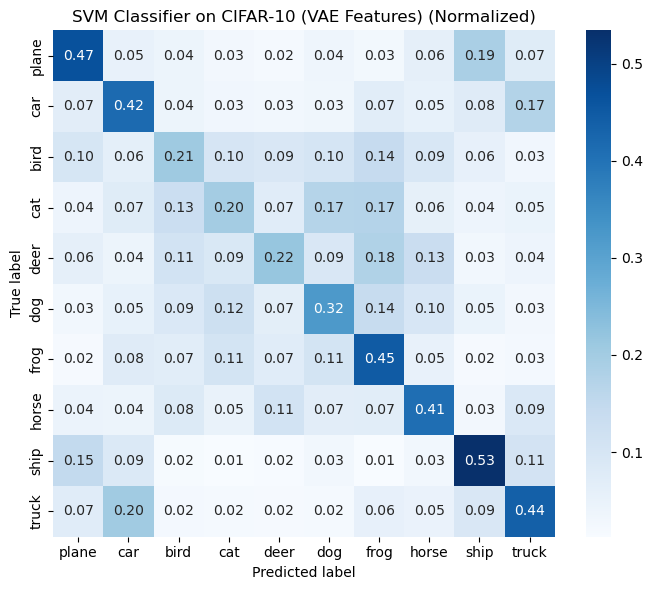

In [37]:
# --- Logistic Regression on UMAP features ---
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
lr_clf.fit(X_train_s, y_train)
y_pred = lr_clf.predict(X_valid_s)
acc = lr_clf.score(X_valid_s, y_valid)

print(f"Validation Accuracy on UMAP(2D): {acc:.4f}\n")
print("Classification Report (Logistic Regression):")
print(classification_report(y_valid, y_pred, digits=4))


plot_confusion_matrix(
    lr_clf,
    X_valid_s,
    y_valid,
    class_names=cifar10_classes,
    title="SVM Classifier on CIFAR-10 (VAE Features)"
)


Test Accuracy on UMAP(2D): 0.3629

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0     0.4341    0.4580    0.4457      1000
           1     0.4049    0.4470    0.4249      1000
           2     0.2483    0.2140    0.2299      1000
           3     0.2529    0.1970    0.2215      1000
           4     0.2933    0.2100    0.2448      1000
           5     0.3235    0.3170    0.3202      1000
           6     0.3534    0.4530    0.3970      1000
           7     0.3800    0.3800    0.3800      1000
           8     0.4339    0.5090    0.4685      1000
           9     0.4233    0.4440    0.4334      1000

    accuracy                         0.3629     10000
   macro avg     0.3547    0.3629    0.3566     10000
weighted avg     0.3547    0.3629    0.3566     10000



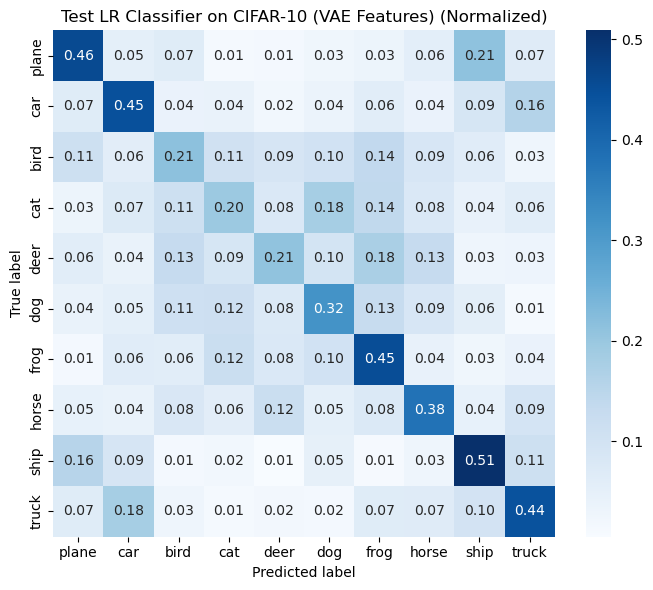

In [38]:
# --- Logistic Regression on UMAP features ---
# lr_clf = LogisticRegression(max_iter=1000, random_state=42)
# lr_clf.fit(X_train_s, y_train)
y_pred = lr_clf.predict(X_test_s)
acc = lr_clf.score(X_test_s, y_test)

print(f"Test Accuracy on UMAP(2D): {acc:.4f}\n")
print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred, digits=4))


plot_confusion_matrix(
    lr_clf,
    X_test_s,
    y_test,
    class_names=cifar10_classes,
    title="Test LR Classifier on CIFAR-10 (VAE Features)"
)


## Support vector machine

[SVM] Accuracy: 0.3578
              precision    recall  f1-score   support

           0     0.4087    0.4713    0.4378      1012
           1     0.3415    0.4247    0.3785      1022
           2     0.2995    0.1207    0.1721      1027
           3     0.2800    0.1352    0.1823       984
           4     0.3086    0.1347    0.1875       958
           5     0.3186    0.3376    0.3279      1004
           6     0.3254    0.4675    0.3837       999
           7     0.3573    0.4250    0.3882       960
           8     0.4237    0.5808    0.4900      1009
           9     0.3907    0.4693    0.4264      1025

    accuracy                         0.3578     10000
   macro avg     0.3454    0.3567    0.3374     10000
weighted avg     0.3457    0.3578    0.3382     10000



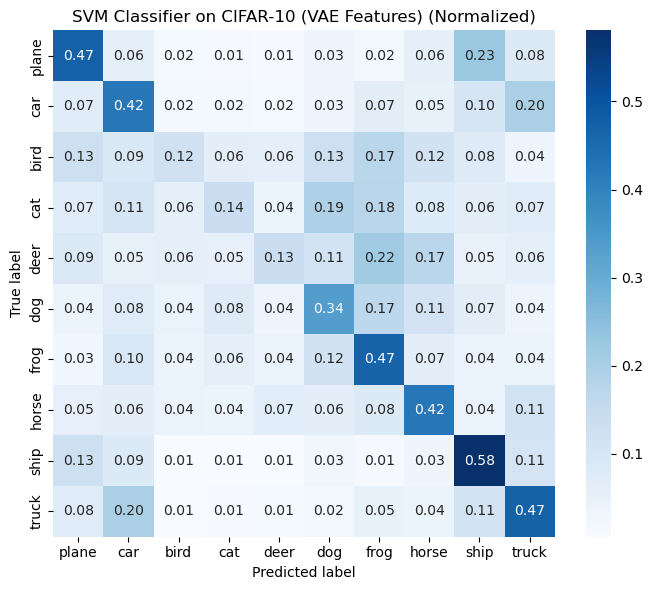

In [39]:
svm_clf: Pipeline = make_pipeline(
    StandardScaler(),
    LinearSVC(dual=False, C=1.0, max_iter=5000, random_state=42)
)

svm_clf.fit(X_train_s, y_train)

# Evaluate on valid features
evaluate_classifier(clf=svm_clf, 
                    X=X_valid_s, 
                    y=y_valid, 
                    name="SVM")

plot_confusion_matrix(
    svm_clf,
    X_valid_s,
    y_valid,
    class_names=cifar10_classes,
    title="SVM Classifier on CIFAR-10 (VAE Features)"
)

## MLP classifier

[INFO] Device: cuda
[INFO] Input dim = 64, Num classes = 10
[INFO] Training MLP...
Epoch 01 | train_loss=1.9792 | val_loss=1.7527 | train_acc=0.2883 | val_acc=0.3844
Epoch 02 | train_loss=1.7404 | val_loss=1.6396 | train_acc=0.3809 | val_acc=0.4238


Epoch 03 | train_loss=1.6577 | val_loss=1.5723 | train_acc=0.4103 | val_acc=0.4480
Epoch 04 | train_loss=1.6038 | val_loss=1.5301 | train_acc=0.4303 | val_acc=0.4592
Epoch 05 | train_loss=1.5649 | val_loss=1.4986 | train_acc=0.4423 | val_acc=0.4746
Epoch 06 | train_loss=1.5363 | val_loss=1.4777 | train_acc=0.4542 | val_acc=0.4802
Epoch 07 | train_loss=1.5121 | val_loss=1.4613 | train_acc=0.4634 | val_acc=0.4855
Epoch 08 | train_loss=1.4926 | val_loss=1.4427 | train_acc=0.4688 | val_acc=0.4953
Epoch 09 | train_loss=1.4718 | val_loss=1.4291 | train_acc=0.4764 | val_acc=0.4965
Epoch 10 | train_loss=1.4634 | val_loss=1.4244 | train_acc=0.4772 | val_acc=0.4966
Epoch 11 | train_loss=1.4476 | val_loss=1.4134 | train_acc=0.4856 | val_acc=0.4988
Epoch 12 | train_loss=1.4391 | val_loss=1.4050 | train_acc=0.4860 | val_acc=0.5007
Epoch 13 | train_loss=1.4230 | val_loss=1.4017 | train_acc=0.4924 | val_acc=0.5057
Epoch 14 | train_loss=1.4190 | val_loss=1.3946 | train_acc=0.4934 | val_acc=0.5077
Epoc

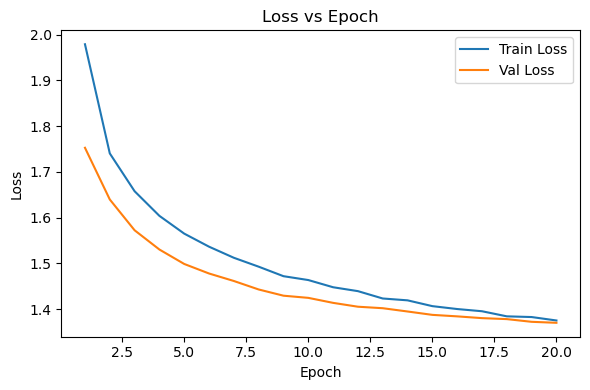

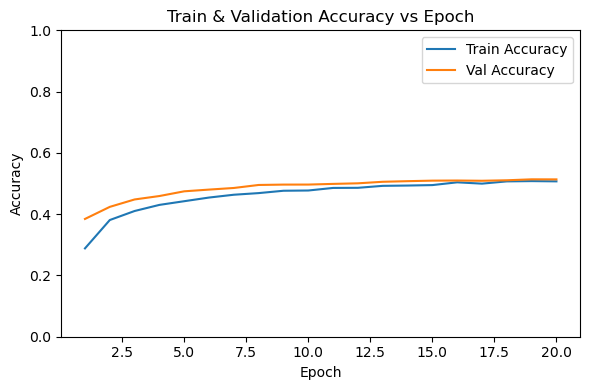

In [64]:
# ===== PyTorch MLP with Train / Val / Test + Accuracy Plot + Regularization (Fixed) =====
import numpy as np
import torch
from torch import nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ------------------------- Setup -------------------------
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", device)

# ------------------------- Data (expects X_train_s, etc.) -------------------------
X_train = torch.tensor(X_train_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_valid = torch.tensor(X_valid_s, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid, dtype=torch.long)
X_test  = torch.tensor(X_test_s,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# Standardize using train stats
mu  = X_train.mean(0, keepdim=True)
std = X_train.std(0, keepdim=True).clamp_min(1e-6)
X_train = (X_train - mu) / std
X_valid = (X_valid - mu) / std
X_test  = (X_test  - mu) / std

X_train = X_train.to(device); y_train_t = y_train_t.to(device)
X_valid = X_valid.to(device); y_valid_t = y_valid_t.to(device)
X_test  = X_test.to(device);  y_test_t  = y_test_t.to(device)

# ------------------------- Hyperparams -------------------------
dropout_p    = 0.2
weight_decay = 1e-4
lr           = 1e-3
batch_size   = 256
epochs       = 20
use_early_stopping = True
patience     = 5

# ------------------------- Model (Fixed Architecture) -------------------------
in_dim = X_train.shape[1]
n_classes = int(y_train_t.max().item() + 1)

print(f"[INFO] Input dim = {in_dim}, Num classes = {n_classes}")

model = nn.Sequential(
    nn.Linear(in_dim, 128), nn.ReLU(),
    nn.Dropout(dropout_p),
    nn.Linear(128, 64),     nn.ReLU(),
    nn.Dropout(dropout_p),
    nn.Linear(64, n_classes)
).to(device)

opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

# ------------------------- Train -------------------------
print("[INFO] Training MLP...")
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = -1.0
best_state = None
epochs_no_improve = 0

for epoch in range(1, epochs + 1):
    model.train()
    perm = torch.randperm(X_train.size(0), device=device)
    total_loss = 0.0
    correct_train = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb, yb = X_train[idx], y_train_t[idx]
        logits = model(xb)
        loss = loss_fn(logits, yb)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        total_loss += loss.item() * xb.size(0)
        correct_train += (logits.argmax(1) == yb).sum().item()

    train_loss = total_loss / X_train.size(0)
    train_acc = correct_train / X_train.size(0)

    model.eval()
    with torch.no_grad():
        logits_val = model(X_valid)
        val_loss = loss_fn(logits_val, y_valid_t).item()
        preds_val = logits_val.argmax(1)
        val_acc = (preds_val == y_valid_t).float().mean().item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} "
          f"| train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    # early stopping
    if use_early_stopping:
        if val_acc > best_val_acc + 1e-6:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[INFO] Early stopping at epoch {epoch} (best val_acc={best_val_acc:.4f}).")
                break

if use_early_stopping and best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# ------------------------- Evaluation -------------------------
def evaluate_split(X_tensor, y_np, name="Split"):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).argmax(1).cpu().numpy()
    acc = accuracy_score(y_np, y_pred)
    print(f"\n[{name} Accuracy]: {acc:.4f}")
    print(f"Classification Report ({name}):")
    print(classification_report(y_np, y_pred, digits=4))
    return y_pred, acc

y_pred_valid, valid_acc = evaluate_split(X_valid, y_valid, name="Validation")
y_pred_test, test_acc   = evaluate_split(X_test,  y_test,  name="Test")

# ------------------------- Plots -------------------------
epochs_axis = range(1, len(train_losses) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, train_losses, label="Train Loss")
plt.plot(epochs_axis, val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_axis, train_accs, label="Train Accuracy")
plt.plot(epochs_axis, val_accs, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Train & Validation Accuracy vs Epoch")
plt.ylim(0, 1)
plt.legend(); plt.tight_layout(); plt.show()